In [1]:
# Uninstall current PyTorch and related packages
#!pip uninstall -y torch torchvision torchaudio

# Reinstall compatible version with CUDA 12.1
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install required packages
!pip install --no-deps pytorch-lightning==2.4.0
!pip install lightning-utilities torchmetrics
!pip install scikit-learn matplotlib

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import random
from collections import defaultdict
import pytorch_lightning as pl
import copy

# Verify torch version and GPU availability
print("Torch version:", torch.__version__)
if torch.cuda.is_available():
    print("GPU is available:", torch.cuda.get_device_name(0))
    print(torch.rand(2,2).cuda())
else:
    print("GPU is not available. To enable GPU, go to Runtime > Change runtime type > GPU.")


Looking in indexes: https://download.pytorch.org/whl/cu121
Torch version: 2.5.1+cu121
GPU is available: NVIDIA A100-SXM4-40GB
tensor([[0.1987, 0.7223],
        [0.8210, 0.9254]], device='cuda:0')


In [2]:
# Define global device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load datasets
full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Split into labeled and unlabeled pools
def split_dataset(dataset, initial_labeled=10):
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    labeled_indices = indices[:initial_labeled]
    unlabeled_indices = indices[initial_labeled:]
    return labeled_indices, unlabeled_indices

# Initialize random indices once
labeled_indices, unlabeled_indices = split_dataset(full_train_set, initial_labeled=10)


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Clone the TypiClust repository (if not already cloned)
import os
if not os.path.exists('TypiClust'):
    !git clone https://github.com/avihu111/TypiClust.git

import sys
sys.path.append('/content/TypiClust/scan/models')

from google.colab import drive
import torch
import torch.nn as nn
import torchvision
from resnet_cifar import resnet18  # Import the custom ResNet from resnet_cifar.py

# ------------------------------
# SIMCLR MODEL AND FEATURE EXTRACTOR
# ------------------------------
class SimCLR(nn.Module):
    def __init__(self, feature_dim=128):
        super(SimCLR, self).__init__()
        resnet_dict = resnet18(in_channel=3)
        self.backbone = resnet_dict['backbone']
        in_features = resnet_dict['dim']
        self.projection_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, feature_dim)
        )

    def forward(self, x):
        features = self.backbone(x)
        proj = self.projection_head(features)
        return proj

def load_pretrained_simclr_improved(model_path):
    model = SimCLR(feature_dim=128)
    try:
        checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
    except Exception as e:
        print(f"Warning: weights_only loading failed ({str(e)}), falling back")
        checkpoint = torch.load(model_path, map_location='cpu')
    adjusted_state_dict = {}
    for key, value in checkpoint.items():
      if key.startswith("contrastive_head."):
        new_key = key.replace("contrastive_head.", "projection_head.")
      else:
        new_key = key
      adjusted_state_dict[new_key] = value
    missing_keys, unexpected_keys = model.load_state_dict(adjusted_state_dict, strict=False)
    print("Missing keys:", missing_keys)
    print("Unexpected keys:", unexpected_keys)
    return model

class AdvancedFeatureExtractor(nn.Module):
    def __init__(self, simclr_model, common_dim=128):
        super(AdvancedFeatureExtractor, self).__init__()
        self.backbone = simclr_model.backbone
        self._feature_dim = None
        self.features = {}

        # Register hooks on multiple layers
        self.backbone.layer1.register_forward_hook(self.get_features_hook('layer1'))
        self.backbone.layer2.register_forward_hook(self.get_features_hook('layer2'))
        self.backbone.layer3.register_forward_hook(self.get_features_hook('layer3'))

        # Projection layers: project layer1, layer2, and layer3 features to a common dimension.
        # Based on your output, layer1 outputs 64 channels, layer2 128, layer3 256.
        self.proj1 = nn.Linear(64, common_dim)   # from layer1
        self.proj2 = nn.Linear(128, common_dim)   # from layer2
        self.proj3 = nn.Linear(256, common_dim)   # from layer3

        # Create a dummy input on the global device.
        sample_input = torch.randn(1, 3, 32, 32).to(device)
        with torch.no_grad():
            dummy_out = self.backbone(sample_input)
            dummy_layer1 = F.adaptive_avg_pool2d(self.features.get('layer1', dummy_out), (1,1)).flatten(1)
        intermediate_dim = dummy_layer1.shape[1]


        self.attention_fc = nn.Sequential(
            nn.Linear(common_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 3), # one weight per branch
            nn.Softmax(dim=1)
        )

    def get_features_hook(self, name):
        def hook(module, input, output):
            self.features[name] = output.detach()
        return hook

    def forward(self, x):
        self.features = {}
        final_features = self.backbone(x) # Final features from the backbone

        # Pool intermediate features from the hooked layers
        layer1_feat = F.adaptive_avg_pool2d(self.features['layer1'], (1, 1)).flatten(1)
        layer2_feat = F.adaptive_avg_pool2d(self.features['layer2'], (1, 1)).flatten(1)
        layer3_feat = F.adaptive_avg_pool2d(self.features['layer3'], (1, 1)).flatten(1)

        # Project each feature to the common dimension.
        proj1_feat = self.proj1(layer1_feat)
        proj2_feat = self.proj2(layer2_feat)
        proj3_feat = self.proj3(layer3_feat)

        # Stack projected features: shape [B, 3, common_dim]
        intermediate_feats = torch.stack([proj1_feat, proj2_feat, proj3_feat], dim=1)

        # Compute context by averaging the projections
        context = intermediate_feats.mean(dim=1) # shape [B, common_dim]
        att_weights = self.attention_fc(context) # shape [B, 3]
        att_weights = att_weights.unsqueeze(2)      # shape [B, 3, 1]

        # Weighted sum of intermediate features
        aggregated_feats = (intermediate_feats * att_weights).sum(dim=1)  # shape [B, common_dim]

        # Concatenate final backbone features with aggregated intermediate features
        combined = torch.cat([final_features, aggregated_feats], dim=1)

        if self._feature_dim is None:
            self._feature_dim = combined.shape[1]
            print(f"Automatically detected advanced feature dimension: {self._feature_dim}")

        return F.normalize(combined, p=2, dim=1)

    @property
    def feature_dim(self):
        if self._feature_dim is None:
            raise RuntimeError("Feature dimension not determined yet - run a forward pass first")
        return self._feature_dim

# Mount Google Drive for accessing the pretrained weights
drive.mount('/content/drive')

checkpoint_path = "/content/drive/My Drive/cw2_ML/simclr_cifar-10.pth.tar"
simclr_model = load_pretrained_simclr_improved(checkpoint_path)
simclr_model = simclr_model.to(device)
simclr_model.eval()

feature_extractor = AdvancedFeatureExtractor(simclr_model, common_dim=128).to(device)
feature_extractor.eval()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing keys: []
Unexpected keys: []


AdvancedFeatureExtractor(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [8]:
# ------------------------------
# TypiClust Class
# ------------------------------
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from sklearn.metrics import pairwise_distances
from sklearn.mixture import GaussianMixture


class TypiClust:
    def __init__(self, feature_extractor, dataset, max_clusters=100, k_neighbors=10):
        self.feature_extractor = feature_extractor
        self.dataset = dataset
        self.max_clusters = max_clusters
        self.k_neighbors = k_neighbors

    def extract_features(self, indices):
      """Extract features with dimension verification"""
      features = []
      dataloader = DataLoader(Subset(self.dataset, indices), batch_size=256, num_workers=2, shuffle=False)
      with torch.no_grad():
          for images, _ in tqdm(dataloader, desc="Extracting features"):
                features.append(self.feature_extractor(images.to(device)).cpu())
      return torch.cat(features, dim=0).numpy()

    def compute_fast_typicality(self, features, cluster_labels):
        """Faster typicality scoring using Gaussian Mixture and nearest neighbors"""
        unique_labels = np.unique(cluster_labels)
        typicality_scores = np.zeros(len(features))

        # Precompute nearest neighbors for all points
        nbrs = NearestNeighbors(n_neighbors=self.k_neighbors).fit(features)

        for label in unique_labels:
            cluster_mask = (cluster_labels == label)
            if sum(cluster_mask) < 5:  # Skip small clusters
                continue

            # Fit GMM to the cluster
            gmm = GaussianMixture(n_components=1, random_state=42)
            gmm.fit(features[cluster_mask])

            # Get density scores
            densities = np.exp(gmm.score_samples(features[cluster_mask]))

            # Get neighbor distances
            distances, _ = nbrs.kneighbors(features[cluster_mask])
            consistency = 1 / (distances.std(axis=1) + 1e-8)

            # Combine scores
            combined = densities * consistency
            typicality_scores[cluster_mask] = combined

        return typicality_scores


    def select_queries(self, unlabeled_indices, budget, labeled_indices=None):
      """Optimized query selection"""
      if len(unlabeled_indices) <= budget:
            return unlabeled_indices.copy()

      # 1. Extract features (smaller initial sample if dataset is large)
      sample_size = min(5000, len(unlabeled_indices))
      sample_indices = np.random.choice(unlabeled_indices, sample_size, replace=False)
      features = self.extract_features(sample_indices)

      # 2. Cluster with MiniBatchKMeans (faster than full KMeans)
      n_clusters = min(budget, self.max_clusters, len(sample_indices))
      kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
      cluster_labels = kmeans.fit_predict(features)

      # 3. Compute fast typicality
      scores = self.compute_fast_typicality(features, cluster_labels)

      # 4. Select top samples per cluster
      selected = []
      for label in np.unique(cluster_labels):
          cluster_mask = (cluster_labels == label)
          if sum(cluster_mask) == 0:
              continue

          # Get best sample in this cluster
          best_idx = np.argmax(scores[cluster_mask])
          global_idx = np.where(cluster_mask)[0][best_idx]
          selected.append(sample_indices[global_idx])

          if len(selected) >= budget:
               break

      return selected[:budget]


In [5]:

# ------------------------------
# Visualization Helpers
# ------------------------------
def show_typiclust_results(dataset, selected_indices, num_images=30):
    nrows = 5
    ncols = 6
    plt.figure(figsize=(2*ncols, 2*nrows))
    max_images = min(num_images, len(selected_indices), nrows*ncols)
    for i in range(max_images):
        idx = selected_indices[i]
        img, label = dataset[idx]
        if hasattr(img, 'permute'):
            img_np = img.permute(1, 2, 0).cpu().numpy()
        else:
            img_np = img
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img_np)
        plt.title(f"Index {idx}, Label {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def show_label_distribution(dataset, indices, title=""):
    labels = [dataset[i][1] for i in indices]
    label_counts = np.bincount(labels, minlength=10)
    plt.bar(range(10), label_counts, color='blue', alpha=0.7)
    plt.title(f"Class Distribution: {title}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(range(10))
    plt.show()

from sklearn.manifold import TSNE
def compute_tsne(feature_extractor, dataset, indices, n_samples=2000):
    if len(indices) > n_samples:
        indices = random.sample(indices, n_samples)
    feature_extractor.eval()
    loader = DataLoader(Subset(dataset, indices), batch_size=256, shuffle=False)
    all_feats = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            feats = feature_extractor(images).cpu().numpy()
            all_feats.append(feats)
    all_feats = np.concatenate(all_feats, axis=0)
    print("Computing t-SNE on extracted features...")
    tsne = TSNE(n_components=2, init='pca', random_state=42)
    feats_2d = tsne.fit_transform(all_feats)
    return feats_2d, indices

def plot_tsne_colored(feats_2d, indices, labeled_indices_tc, labeled_indices_random):
    labeled_tc_set = set(labeled_indices_tc)
    labeled_random_set = set(labeled_indices_random)
    colors = []
    for idx in indices:
        if idx in labeled_tc_set and idx in labeled_random_set:
            colors.append("yellow")
        elif idx in labeled_tc_set:
            colors.append("blue")
        elif idx in labeled_random_set:
            colors.append("green")
        else:
            colors.append("gray")
    plt.figure(figsize=(8,6))
    plt.scatter(feats_2d[:,0], feats_2d[:,1], c=colors, alpha=0.6, s=10)
    plt.title("t-SNE of CIFAR-10 features: Blue=TypiClust, Green=Random, Gray=Unlabeled")
    plt.axis("off")
    plt.show()


In [6]:
# ------------------------------
# Active Learning Comparison Functions
# ------------------------------
def active_learning_comparison(dataset, initial_labeled=20, budget=20, rounds=5):
    print(f"Using device: {device}")
    # Use the pre-initialized advanced_feature_extractor
    typiclust = TypiClust(feature_extractor, dataset, max_clusters=100)
    model = SupervisedModel().to(device)
    linear_model = LinearClassifier().to(device)
    semi_model = SupervisedModel().to(device)
    labeled_indices_tc, unlabeled_indices_tc = split_dataset(dataset, initial_labeled)
    labeled_indices_random = labeled_indices_tc.copy()
    unlabeled_indices_random = unlabeled_indices.copy()  # Use the same initial random indices
    final_labeled_tc = None
    final_labeled_random = None
    test_loader = DataLoader(test_set, batch_size=256, shuffle=False)
    results = {
        'tc_supervised': [],
        'tc_linear': [],
        'tc_semi': [],
        'random_supervised': [],
        'random_linear': [],
        'random_semi': []
    }
    for rnd in range(rounds):
        print(f"\nRound {rnd+1}/{rounds}")
        print(f"Labeled pool size: {initial_labeled + budget*rnd}")
        print("\nTypiClust Results:")
        labeled_set_tc = Subset(dataset, labeled_indices_tc)
        labeled_loader_tc = DataLoader(labeled_set_tc, batch_size=256, shuffle=True)
        unlabeled_set_tc = Subset(dataset, unlabeled_indices_tc)
        unlabeled_loader_tc = DataLoader(unlabeled_set_tc, batch_size=256, shuffle=True)
        model = SupervisedModel().to(device)
        acc = train_supervised(model, labeled_loader_tc, test_loader)
        results['tc_supervised'].append(acc)
        print(f"Supervised accuracy: {acc:.2%}")
        linear_model = LinearClassifier().to(device)
        acc = train_linear_on_features(linear_model, simclr_model, labeled_loader_tc, test_loader)
        results['tc_linear'].append(acc)
        print(f"Linear accuracy: {acc:.2%}")
        semi_model = SupervisedModel().to(device)
        acc = train_semi_supervised(semi_model, labeled_loader_tc, unlabeled_loader_tc, test_loader)
        results['tc_semi'].append(acc)
        print(f"Semi-supervised accuracy: {acc:.2%}")
        print("\nRandom Sampling Results:")
        labeled_set_random = Subset(dataset, labeled_indices_random)
        labeled_loader_random = DataLoader(labeled_set_random, batch_size=256, shuffle=True)
        unlabeled_set_random = Subset(dataset, unlabeled_indices_random)
        unlabeled_loader_random = DataLoader(unlabeled_set_random, batch_size=256, shuffle=True)
        model = SupervisedModel().to(device)
        acc = train_supervised(model, labeled_loader_random, test_loader)
        results['random_supervised'].append(acc)
        print(f"Supervised accuracy: {acc:.2%}")
        linear_model = LinearClassifier().to(device)
        acc = train_linear_on_features(linear_model, simclr_model, labeled_loader_random, test_loader)
        results['random_linear'].append(acc)
        print(f"Linear accuracy: {acc:.2%}")
        semi_model = SupervisedModel().to(device)
        acc = train_semi_supervised(semi_model, labeled_loader_random, unlabeled_loader_random, test_loader)
        results['random_semi'].append(acc)
        print(f"Semi-supervised accuracy: {acc:.2%}")
        queries_tc = typiclust.select_queries(unlabeled_indices_tc, budget, labeled_indices_tc)
        labeled_indices_tc.extend(queries_tc)
        unlabeled_indices_tc = [idx for idx in unlabeled_indices_tc if idx not in queries_tc]
        queries_random = random.sample(unlabeled_indices_random, budget)
        labeled_indices_random.extend(queries_random)
        unlabeled_indices_random = [idx for idx in unlabeled_indices_random if idx not in queries_random]
        final_labeled_tc = labeled_indices_tc
        final_labeled_random = labeled_indices_random
    return results, final_labeled_tc, final_labeled_random, unlabeled_indices_tc, unlabeled_indices_random

def active_learning_comparison_trials(dataset, initial_labeled=20, budget=20, rounds=5, trials=5):
    all_results = {
        'tc_supervised': [],
        'tc_linear': [],
        'tc_semi': [],
        'random_supervised': [],
        'random_linear': [],
        'random_semi': []
    }
    final_indices_storage = []
    trial_results_list = []
    for trial in range(trials):
        print(f"\n=== Trial {trial+1}/{trials} ===")
        results, final_tc, final_random, final_unlab_tc, final_unlab_rand = active_learning_comparison(
            dataset, initial_labeled=initial_labeled, budget=budget, rounds=rounds)
        trial_results_list.append(results)
        plot_single_trial_results(results, trial+1, initial_labeled, budget, rounds)
        for key in all_results.keys():
            all_results[key].append(results[key])
        final_indices_storage.append((final_tc, final_random, final_unlab_tc, final_unlab_rand))
    avg_results = {key: np.mean(all_results[key], axis=0) for key in all_results}
    std_results = {key: np.std(all_results[key], axis=0) for key in all_results}
    return avg_results, std_results, final_indices_storage

def plot_avg_results(avg_results, std_results, initial_labeled, budget, rounds):
    x_vals = np.arange(rounds) * budget + initial_labeled
    plt.figure(figsize=(8, 6))
    plt.errorbar(
        x_vals,
        avg_results['tc_supervised'],
        yerr=std_results['tc_supervised'],
        fmt='o-',
        capsize=4,
        label='TypiClust (Supervised)'
    )
    plt.errorbar(
        x_vals,
        avg_results['random_supervised'],
        yerr=std_results['random_supervised'],
        fmt='o--',
        capsize=4,
        label='Random (Supervised)'
    )
    plt.errorbar(
        x_vals,
        avg_results['tc_linear'],
        yerr=std_results['tc_linear'],
        fmt='s-',
        capsize=4,
        label='TypiClust (Linear)'
    )
    plt.errorbar(
        x_vals,
        avg_results['random_linear'],
        yerr=std_results['random_linear'],
        fmt='s--',
        capsize=4,
        label='Random (Linear)'
    )
    plt.errorbar(
        x_vals,
        avg_results['tc_semi'],
        yerr=std_results['tc_semi'],
        fmt='^-',
        capsize=4,
        label='TypiClust (Semi-supervised)'
    )
    plt.errorbar(
        x_vals,
        avg_results['random_semi'],
        yerr=std_results['random_semi'],
        fmt='^--',
        capsize=4,
        label='Random (Semi-supervised)'
     )
    plt.xlabel('Number of Labeled Examples')
    plt.ylabel('Test Accuracy')
    plt.title('Active Learning Comparison (Average of Multiple Trials)')
    plt.xticks(x_vals)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_single_trial_results(results, trial_number, initial_labeled, budget, rounds):
    plt.figure(figsize=(8, 6))
    x_vals = np.arange(rounds) * budget + initial_labeled
    plt.plot(x_vals, results['tc_supervised'], 'o-', label='TypiClust (Supervised)')
    plt.plot(x_vals, results['tc_linear'], 's-', label='TypiClust (Linear)')
    plt.plot(x_vals, results['tc_semi'], '^-', label='TypiClust (Semi)')
    plt.plot(x_vals, results['random_supervised'], 'o--', label='Random (Supervised)')
    plt.plot(x_vals, results['random_linear'], 's--', label='Random (Linear)')
    plt.plot(x_vals, results['random_semi'], '^--', label='Random (Semi)')
    plt.title(f"Active Learning Comparison - Trial {trial_number}")
    plt.xlabel('Number of Labeled Examples')
    plt.ylabel('Test Accuracy')
    plt.xticks(x_vals)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()



=== Trial 1/5 ===
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Round 1/5
Labeled pool size: 20

TypiClust Results:
Supervised accuracy: 16.29%
Linear accuracy: 22.25%
Semi-supervised accuracy: 18.61%

Random Sampling Results:
Supervised accuracy: 16.27%
Linear accuracy: 22.49%
Semi-supervised accuracy: 17.71%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.98it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 2/5
Labeled pool size: 40

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 19.20%
Linear accuracy: 33.21%
Semi-supervised accuracy: 23.41%

Random Sampling Results:
Supervised accuracy: 18.25%
Linear accuracy: 28.16%
Semi-supervised accuracy: 18.07%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.84it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 3/5
Labeled pool size: 60

TypiClust Results:
Supervised accuracy: 20.32%
Linear accuracy: 38.07%
Semi-supervised accuracy: 23.27%

Random Sampling Results:
Supervised accuracy: 16.75%
Linear accuracy: 33.31%
Semi-supervised accuracy: 21.66%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.68it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 4/5
Labeled pool size: 80

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 19.32%
Linear accuracy: 45.03%
Semi-supervised accuracy: 30.62%

Random Sampling Results:
Supervised accuracy: 16.44%
Linear accuracy: 40.17%
Semi-supervised accuracy: 24.21%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 5/5
Labeled pool size: 100

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 25.07%
Linear accuracy: 46.03%
Semi-supervised accuracy: 26.79%

Random Sampling Results:
Supervised accuracy: 24.02%
Linear accuracy: 43.24%
Semi-supervised accuracy: 24.19%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i

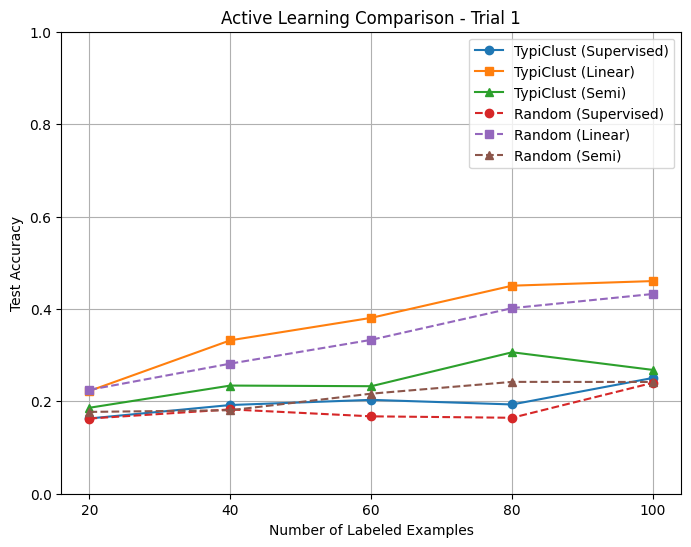


=== Trial 2/5 ===
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Round 1/5
Labeled pool size: 20

TypiClust Results:
Supervised accuracy: 19.43%
Linear accuracy: 23.40%
Semi-supervised accuracy: 18.75%

Random Sampling Results:
Supervised accuracy: 13.48%
Linear accuracy: 23.38%
Semi-supervised accuracy: 20.16%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.75it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 2/5
Labeled pool size: 40

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 22.05%
Linear accuracy: 30.82%
Semi-supervised accuracy: 23.06%

Random Sampling Results:
Supervised accuracy: 21.97%
Linear accuracy: 32.01%
Semi-supervised accuracy: 23.73%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 3/5
Labeled pool size: 60

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 21.68%
Linear accuracy: 36.96%
Semi-supervised accuracy: 24.62%

Random Sampling Results:
Supervised accuracy: 23.85%
Linear accuracy: 38.25%
Semi-supervised accuracy: 21.97%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.90it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 4/5
Labeled pool size: 80

TypiClust Results:
Supervised accuracy: 24.82%
Linear accuracy: 44.06%
Semi-supervised accuracy: 25.10%

Random Sampling Results:
Supervised accuracy: 26.67%
Linear accuracy: 44.33%
Semi-supervised accuracy: 25.68%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.88it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 5/5
Labeled pool size: 100

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 27.97%
Linear accuracy: 46.14%
Semi-supervised accuracy: 27.16%

Random Sampling Results:
Supervised accuracy: 28.17%
Linear accuracy: 47.90%
Semi-supervised accuracy: 30.56%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i

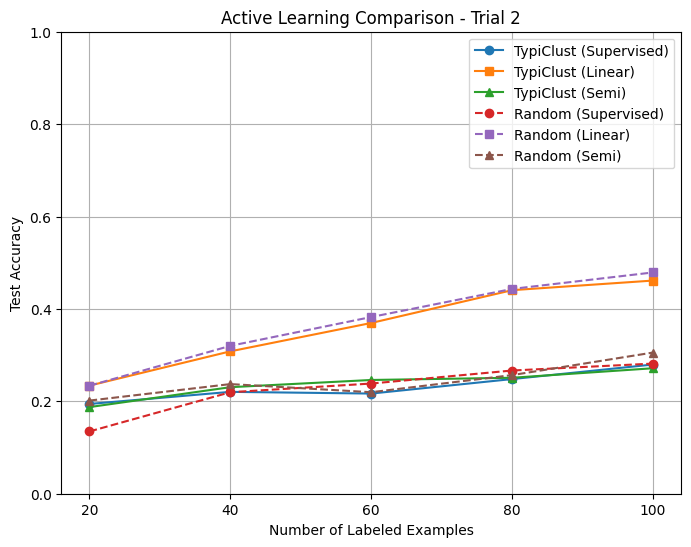


=== Trial 3/5 ===
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Round 1/5
Labeled pool size: 20

TypiClust Results:
Supervised accuracy: 21.26%
Linear accuracy: 24.87%
Semi-supervised accuracy: 19.50%

Random Sampling Results:
Supervised accuracy: 19.99%
Linear accuracy: 25.13%
Semi-supervised accuracy: 18.83%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 2/5
Labeled pool size: 40

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 19.13%
Linear accuracy: 32.23%
Semi-supervised accuracy: 17.85%

Random Sampling Results:
Supervised accuracy: 21.11%
Linear accuracy: 31.07%
Semi-supervised accuracy: 22.88%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.75it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 3/5
Labeled pool size: 60

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 20.74%
Linear accuracy: 37.99%
Semi-supervised accuracy: 23.23%

Random Sampling Results:
Supervised accuracy: 21.49%
Linear accuracy: 35.83%
Semi-supervised accuracy: 24.86%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.66it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 4/5
Labeled pool size: 80

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 24.25%
Linear accuracy: 43.97%
Semi-supervised accuracy: 26.86%

Random Sampling Results:
Supervised accuracy: 24.50%
Linear accuracy: 37.63%
Semi-supervised accuracy: 23.59%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 5/5
Labeled pool size: 100

TypiClust Results:
Supervised accuracy: 22.20%
Linear accuracy: 46.42%
Semi-supervised accuracy: 27.09%

Random Sampling Results:
Supervised accuracy: 18.99%
Linear accuracy: 42.04%
Semi-supervised accuracy: 26.00%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i

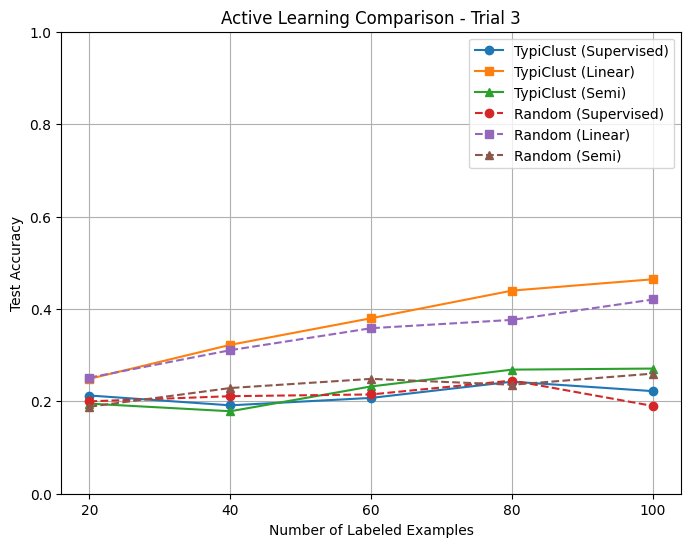


=== Trial 4/5 ===
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Round 1/5
Labeled pool size: 20

TypiClust Results:
Supervised accuracy: 19.75%
Linear accuracy: 25.15%
Semi-supervised accuracy: 17.97%

Random Sampling Results:
Supervised accuracy: 18.07%
Linear accuracy: 23.16%
Semi-supervised accuracy: 21.41%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 2/5
Labeled pool size: 40

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 19.29%
Linear accuracy: 33.38%
Semi-supervised accuracy: 23.57%

Random Sampling Results:
Supervised accuracy: 21.11%
Linear accuracy: 34.35%
Semi-supervised accuracy: 19.52%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 3/5
Labeled pool size: 60

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 21.81%
Linear accuracy: 38.93%
Semi-supervised accuracy: 27.25%

Random Sampling Results:
Supervised accuracy: 18.19%
Linear accuracy: 38.52%
Semi-supervised accuracy: 25.62%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.52it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 4/5
Labeled pool size: 80

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 17.98%
Linear accuracy: 42.92%
Semi-supervised accuracy: 26.42%

Random Sampling Results:
Supervised accuracy: 19.85%
Linear accuracy: 42.65%
Semi-supervised accuracy: 28.93%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.77it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 5/5
Labeled pool size: 100

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 26.49%
Linear accuracy: 45.72%
Semi-supervised accuracy: 29.93%

Random Sampling Results:
Supervised accuracy: 25.22%
Linear accuracy: 46.05%
Semi-supervised accuracy: 29.57%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.84it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i

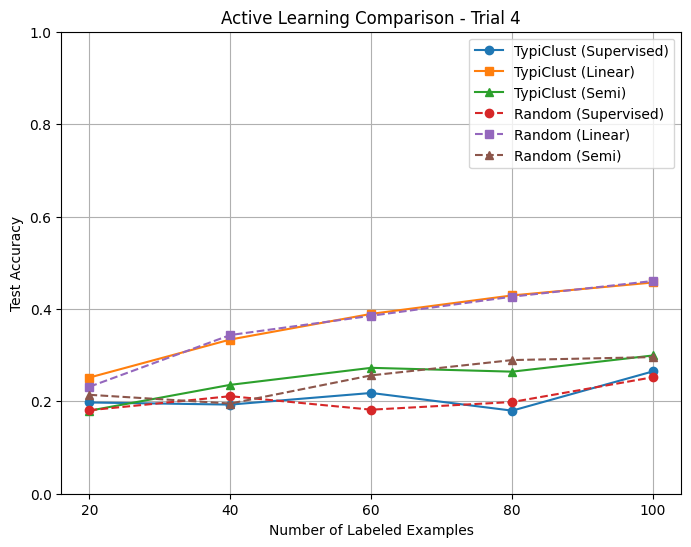


=== Trial 5/5 ===
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Round 1/5
Labeled pool size: 20

TypiClust Results:
Supervised accuracy: 11.12%
Linear accuracy: 25.29%
Semi-supervised accuracy: 19.27%

Random Sampling Results:
Supervised accuracy: 13.30%
Linear accuracy: 26.39%
Semi-supervised accuracy: 15.06%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.85it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 2/5
Labeled pool size: 40

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 22.22%
Linear accuracy: 29.59%
Semi-supervised accuracy: 19.77%

Random Sampling Results:
Supervised accuracy: 16.35%
Linear accuracy: 33.17%
Semi-supervised accuracy: 20.85%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 3/5
Labeled pool size: 60

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 15.24%
Linear accuracy: 33.95%
Semi-supervised accuracy: 24.15%

Random Sampling Results:
Supervised accuracy: 23.91%
Linear accuracy: 37.41%
Semi-supervised accuracy: 27.60%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.80it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 4/5
Labeled pool size: 80

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 17.11%
Linear accuracy: 37.22%
Semi-supervised accuracy: 29.60%

Random Sampling Results:
Supervised accuracy: 26.53%
Linear accuracy: 44.30%
Semi-supervised accuracy: 30.67%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.81it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i


Round 5/5
Labeled pool size: 100

TypiClust Results:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Supervised accuracy: 28.11%
Linear accuracy: 42.19%
Semi-supervised accuracy: 26.23%

Random Sampling Results:
Supervised accuracy: 19.86%
Linear accuracy: 45.72%
Semi-supervised accuracy: 29.89%


Extracting features: 100%|██████████| 20/20 [00:02<00:00,  7.94it/s]
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered in exp
  densities = np.exp(gmm.score_samples(features[cluster_mask]))
<ipython-input-8-957a669b039f>:44: RuntimeWarning: overflow encountered i

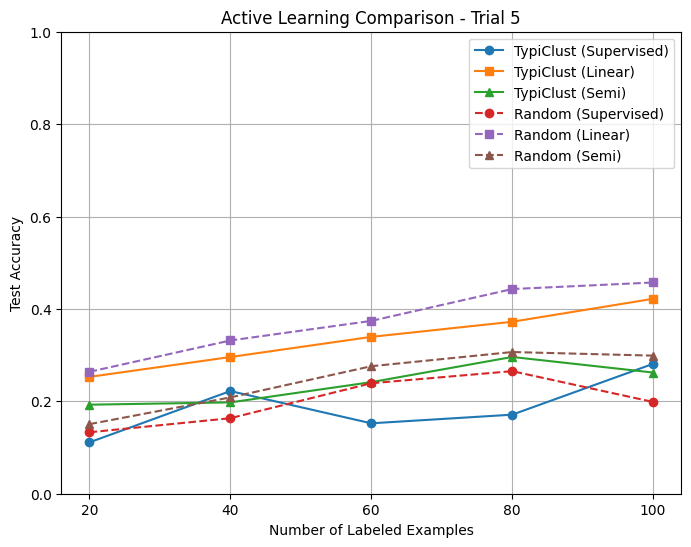

Final average test accuracy (TypiClust Supervised): 25.97%
Final average test accuracy (Random Supervised):   23.25%
Final average test accuracy (TypiClust Linear): 45.30%
Final average test accuracy (Random Linear):   44.99%
Final average test accuracy (TypiClust Semi): 27.44%
Final average test accuracy (Random Semi):   28.04%


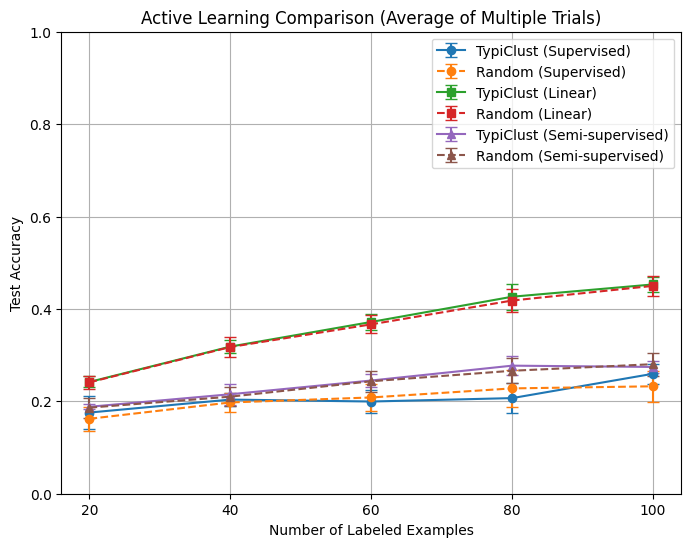

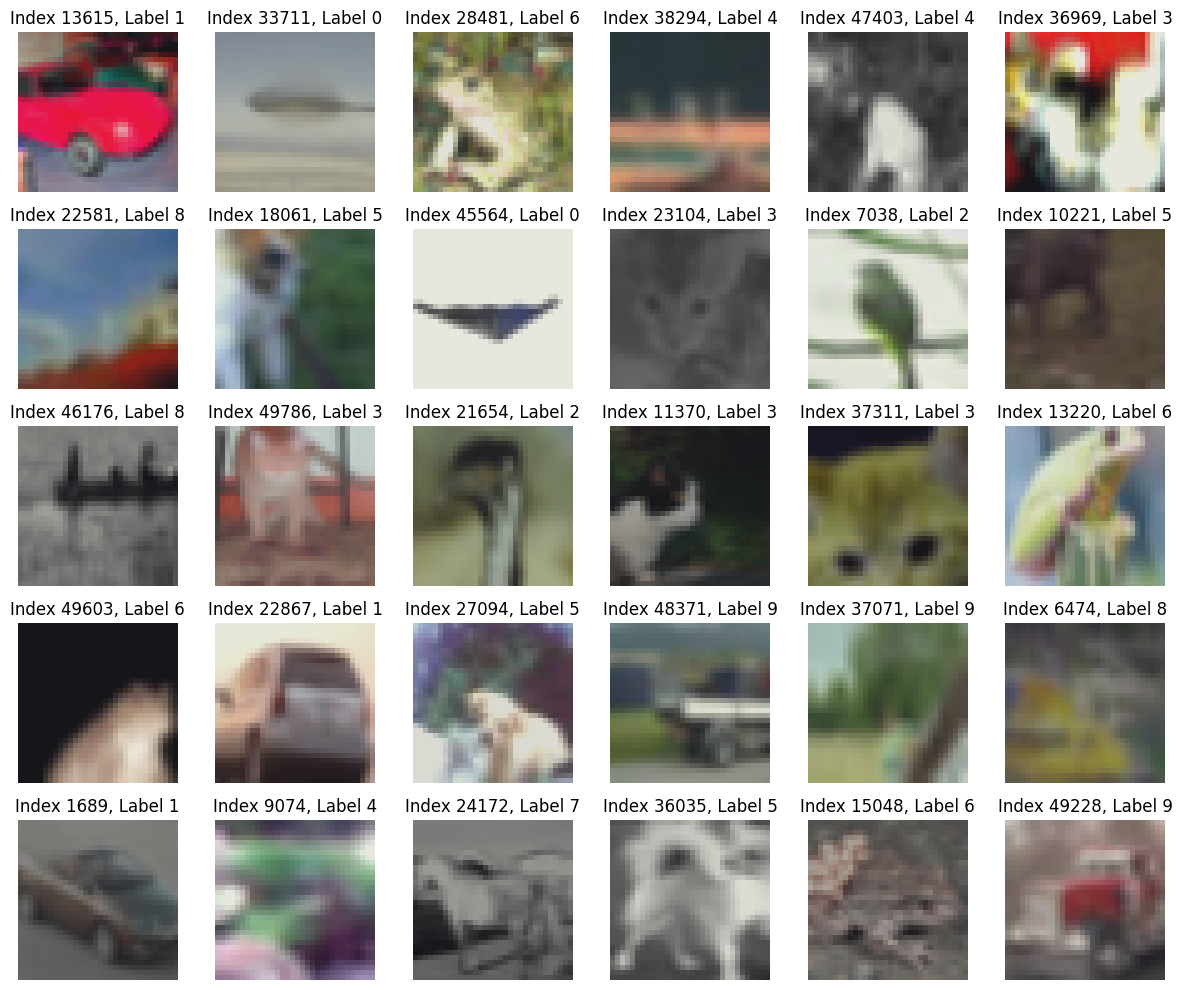


=== Label Distributions ===


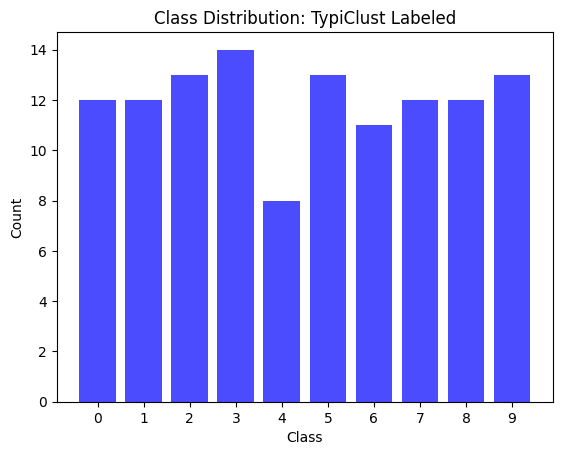

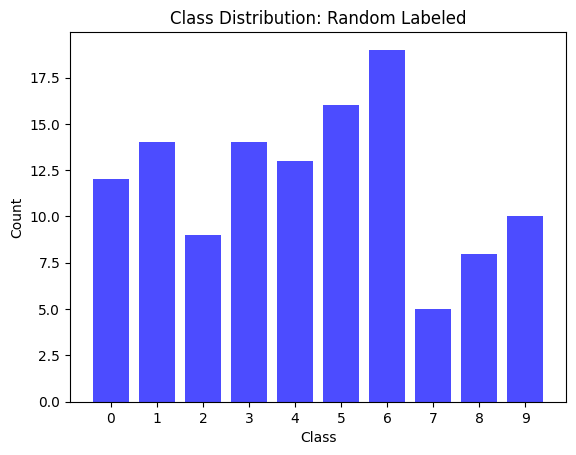

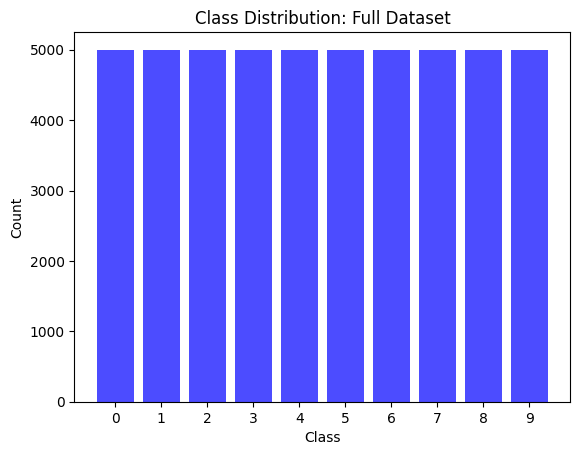

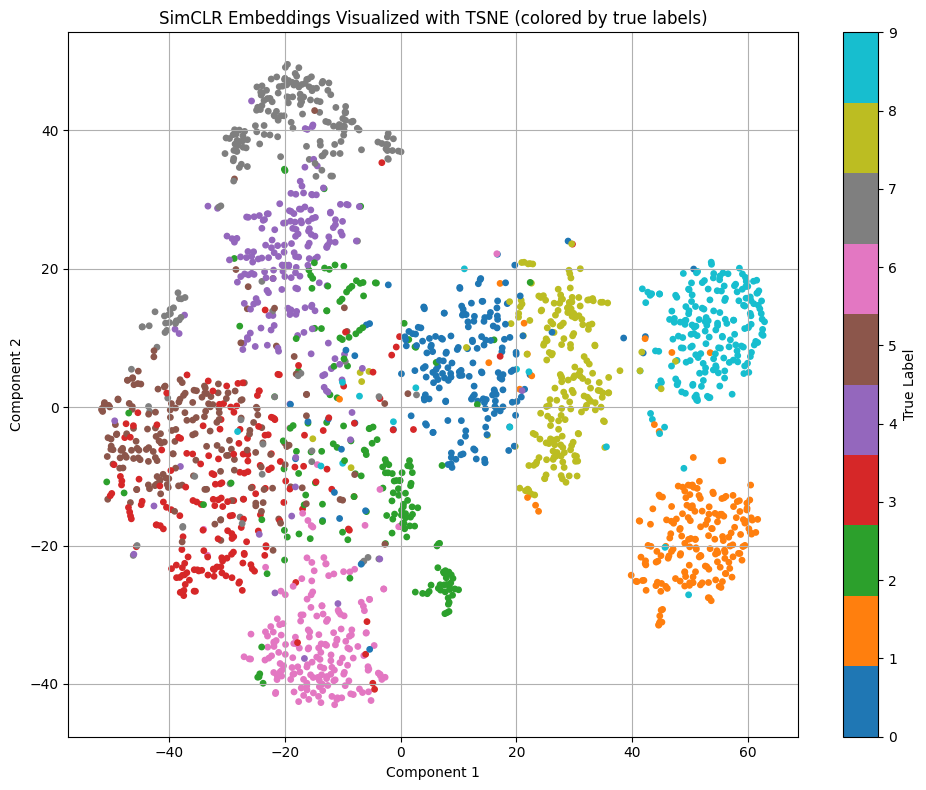

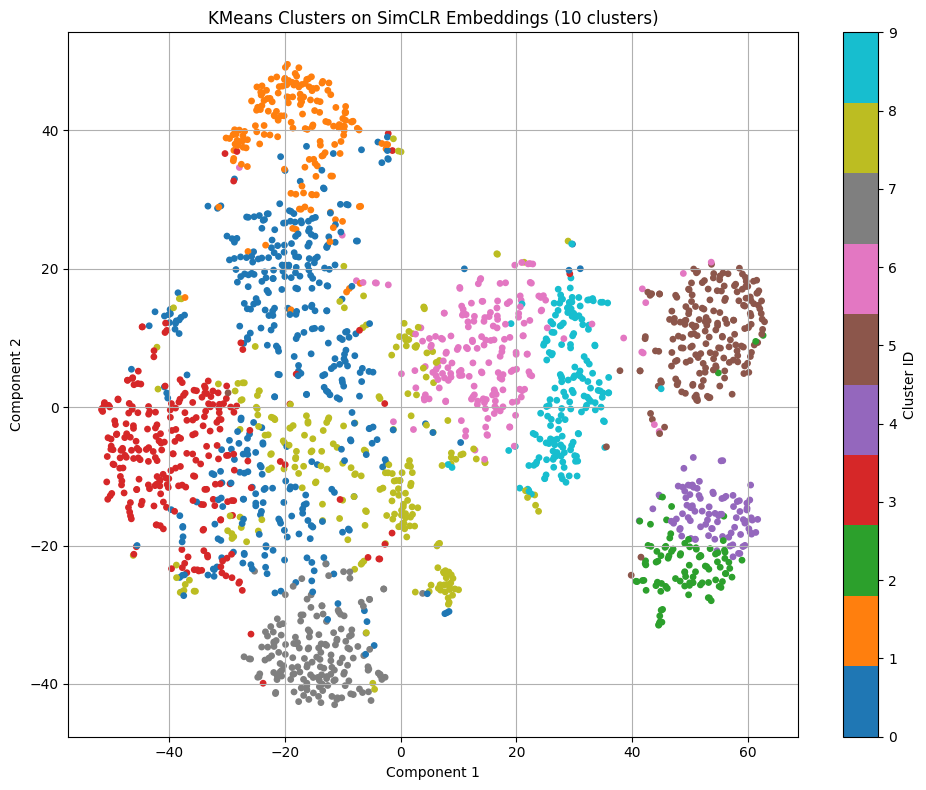

In [9]:
# ------------------------------
# Supervised, Linear, and Semi-supervised Training
# ------------------------------
import torch.optim as optim

class SupervisedModel(nn.Module):
    def __init__(self, num_classes=10):
        super(SupervisedModel, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.maxpool = nn.Identity()
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.resnet(x)

def train_supervised(model, train_loader, test_loader, epochs=200):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=5e-4,
        nesterov=True
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        scheduler.step()
    return evaluate_model(model, test_loader, device)

def evaluate_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

class LinearClassifier(nn.Module):
    def __init__(self, input_dim=128, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

def train_linear_on_features(model, feature_extractor, train_loader, test_loader, epochs=200):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=2.5, momentum=0.9)
    feature_extractor.eval()
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                features = feature_extractor(images)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def train_semi_supervised(model, labeled_loader, unlabeled_loader, test_loader, epochs=100, threshold=0.90):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9, nesterov=True)
    model.train()
    for ep in range(epochs):
        unsup_weight = float(1.0 / (1.0 + np.exp(-5*(ep/epochs - 0.5))))
        unl_iter = iter(unlabeled_loader)
        for inputs_l, labels_l in labeled_loader:
            inputs_l, labels_l = inputs_l.to(device), labels_l.to(device)
            sup_out = model(inputs_l)
            sup_loss = criterion(sup_out, labels_l)
            try:
                inputs_u, _ = next(unl_iter)
            except StopIteration:
                unl_iter = iter(unlabeled_loader)
                inputs_u, _ = next(unl_iter)
            inputs_u = inputs_u.to(device)
            with torch.no_grad():
                out_u = model(inputs_u)
                probs_u = torch.softmax(out_u, dim=1)
                max_probs, pseudo_labels = torch.max(probs_u, dim=1)
            mask = (max_probs >= threshold).float()
            if mask.sum() > 0:
                out_u2 = model(inputs_u)
                unsup_loss = (criterion(out_u2, pseudo_labels) * mask).mean()
            else:
                unsup_loss = torch.tensor(0.0, device=device)
            total_loss = sup_loss + unsup_weight * unsup_loss
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# ------------------------------
# Embedding Visualization
# ------------------------------
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def visualize_embedding_clusters(embeddings, labels, method='tsne', sample_size=2000, n_clusters=10):
    assert method in ['tsne', 'pca'], "method must be 'tsne' or 'pca'"
    np.random.seed(42)
    indices = np.random.choice(len(embeddings), size=sample_size, replace=False)
    emb_subset = embeddings[indices]
    labels_subset = labels[indices]
    if method == 'tsne':
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        reducer = PCA(n_components=2)
    reduced_embs = reducer.fit_transform(emb_subset)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(emb_subset)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embs[:, 0], reduced_embs[:, 1], c=labels_subset, cmap='tab10', s=15)
    plt.title(f"SimCLR Embeddings Visualized with {method.upper()} (colored by true labels)")
    plt.colorbar(scatter, ticks=range(10), label='True Label')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 8))
    scatter2 = plt.scatter(reduced_embs[:, 0], reduced_embs[:, 1], c=cluster_ids, cmap='tab10', s=15)
    plt.title(f"KMeans Clusters on SimCLR Embeddings ({n_clusters} clusters)")
    plt.colorbar(scatter2, ticks=range(n_clusters), label='Cluster ID')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ------------------------------
# RUN THE EXPERIMENT
# ------------------------------
initial_labeled = 20
budget = 20
rounds = 5

labeled_indices, unlabeled_indices = split_dataset(full_train_set, initial_labeled=initial_labeled)

avg_results, std_results, final_indices_storage = active_learning_comparison_trials(
    full_train_set, initial_labeled=initial_labeled, budget=budget, rounds=rounds, trials=5)

final_round_index = rounds - 1

tc_supervised_final = avg_results['tc_supervised'][final_round_index]
random_supervised_final = avg_results['random_supervised'][final_round_index]
print(f"Final average test accuracy (TypiClust Supervised): {tc_supervised_final*100:.2f}%")
print(f"Final average test accuracy (Random Supervised):   {random_supervised_final*100:.2f}%")

tc_linear_final = avg_results['tc_linear'][final_round_index]
random_linear_final = avg_results['random_linear'][final_round_index]
print(f"Final average test accuracy (TypiClust Linear): {tc_linear_final*100:.2f}%")
print(f"Final average test accuracy (Random Linear):   {random_linear_final*100:.2f}%")

tc_semi_final = avg_results['tc_semi'][final_round_index]
random_semi_final = avg_results['random_semi'][final_round_index]
print(f"Final average test accuracy (TypiClust Semi): {tc_semi_final*100:.2f}%")
print(f"Final average test accuracy (Random Semi):   {random_semi_final*100:.2f}%")

plot_avg_results(avg_results, std_results, initial_labeled, budget, rounds)

final_tc, final_random, final_unlab_tc, final_unlab_rand = final_indices_storage[0]
all_indices = final_tc + final_random + final_unlab_tc + final_unlab_rand

show_typiclust_results(full_train_set, final_tc, 30)

print("\n=== Label Distributions ===")
show_label_distribution(full_train_set, final_tc, "TypiClust Labeled")
show_label_distribution(full_train_set, final_random, "Random Labeled")
show_label_distribution(full_train_set, list(range(len(full_train_set))), "Full Dataset")

# Debugging embeddings
loader = DataLoader(full_train_set, batch_size=256, shuffle=False)
all_embeddings = []
all_labels = []
feature_extractor.eval()
with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        feats = feature_extractor(images)
        all_embeddings.append(feats.cpu().numpy())
        all_labels.extend(labels.numpy())
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.array(all_labels)
visualize_embedding_clusters(all_embeddings, all_labels, method='tsne')
